In [ ]:
!pip install -U transformers --quiet
import os, sys
os.kill(os.getpid(), 9)  # force-restart kernel

 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 72.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.4 MB/s eta 0:00:00:00:01

In [ ]:

import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/val_cleaned.csv
/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/train_cleaned.csv
/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/test_cleaned.csv

In [ ]:
import pandas as pd

# Load dataset (update folder name if needed)
train_df = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/train_cleaned.csv")
val_df   = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/val_cleaned.csv")
test_df  = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/test_cleaned.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

print(train_df.head())

In [ ]:
Train shape: (42380, 3)
Validation shape: (9082, 3)
Test shape: (9082, 3)
                                        Headline  \
0                  কলকাতায় বোমা বিস্ফোরণে নিহত ১   
1          ১৫ ঘণ্টা পর ময়মনসিংহের পথে ট্রেন চালু   
2        ময়মনসিংহে আ.লীগের মামলায় আসামি ছাত্রলীগ   
3           পর্ণ দেখার শীর্ষে চট্টগ্রামের ছেলেরা   
4  নড়াইলে কর্তব্যরত অবস্থায় পুলিশ সদস্যের মৃত্যু   

                                             Content  Label  
0  ভারতের পশ্চিমবঙ্গের রাজধানী কলকাতায় একটি বাজার...      3  
1  ময়মনিসংহ স্টেশনের সুপারিনটেনডেন্ট জহিরুল হক জা...      2  
2  ময়মনসিংহ মহানগর আওয়ামী লীগের সভাপতি এহতেশামূল ...      3  
3  বন্দর নগরী চট্টগ্রামে পাশ্চাত্যের ছোঁয়া লেগেছ...      0  
4  নড়াইলের কালিয়ায় কর্তব্যরত অবস্থায় হৃদরোগে আক্র...      3  

In [ ]:
# BULLETPROOF Version - Handles all data issues
import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report
import logging
import os

# Set environment variable to avoid tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up logging
logging.basicConfig(level=logging.INFO)

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print(f"Transformers version: {transformers.__version__}")

# Load the full datasets
print("Loading and cleaning datasets...")
train_df = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/train_cleaned.csv")
val_df   = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/val_cleaned.csv")
test_df  = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/test_cleaned.csv")

def bulletproof_clean_dataset(df, name):
    """Ultra-robust data cleaning"""
    print(f"\n🧹 Cleaning {name} dataset...")
    original_size = len(df)
    
    # Show initial state
    print(f"  Original size: {original_size}")
    print(f"  Columns: {list(df.columns)}")
    
    # Handle missing values in text columns
    for col in ['Headline', 'Content']:
        if col in df.columns:
            missing_count = df[col].isna().sum()
            print(f"  Missing values in {col}: {missing_count}")
            
            # Fill NaN with empty string and convert to string
            df[col] = df[col].fillna('')
            df[col] = df[col].astype(str)
            
            # Clean weird values that might not be strings
            df[col] = df[col].apply(lambda x: str(x) if x is not None else '')
            df[col] = df[col].apply(lambda x: '' if x.lower() in ['nan', 'none', 'null'] else x)
    
    # Handle labels
    if 'Label' in df.columns:
        print(f"  Missing labels: {df['Label'].isna().sum()}")
        df = df[df['Label'].notna()]  # Remove rows with missing labels
        df['Label'] = df['Label'].astype(int)  # Ensure labels are integers
    
    # Create combined text and check for validity
    df['combined_text'] = df['Headline'].astype(str) + ' ' + df['Content'].astype(str)
    df['combined_text'] = df['combined_text'].str.strip()
    
    # Remove rows with empty text
    empty_text = (df['combined_text'] == '') | (df['combined_text'].str.len() < 3)
    df = df[~empty_text]
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['combined_text', 'Label'])
    
    # Final validation - ensure everything is clean
    df = df.reset_index(drop=True)
    
    final_size = len(df)
    print(f"  Final size: {final_size} ({original_size - final_size} removed)")
    
    # Validate the cleaning worked
    sample_text = df['combined_text'].iloc[0]
    print(f"  Sample text type: {type(sample_text)}")
    print(f"  Sample text preview: '{sample_text[:100]}...'")
    
    return df

# Clean all datasets
train_df = bulletproof_clean_dataset(train_df, "Train")
val_df = bulletproof_clean_dataset(val_df, "Validation") 
test_df = bulletproof_clean_dataset(test_df, "Test")

# Show final stats
print(f"\n📊 Final dataset sizes:")
print(f"  Train: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")

# Analyze class distribution
print(f"\n📈 Label distribution in training set:")
label_counts = train_df['Label'].value_counts().sort_index()
total_samples = len(train_df)
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"  Class {label}: {count:,} samples ({percentage:.1f}%)")

# Load tokenizer and model
model_name = "sagorsarker/bangla-bert-base"
print(f"\n🤖 Loading model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

class BulletproofNewsDataset(Dataset):
    """Ultra-robust dataset class with extensive error handling"""
    
    def __init__(self, df, tokenizer, max_len=256):
        print(f"🔧 Creating dataset from {len(df)} samples...")
        
        self.texts = []
        self.labels = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        # Process each sample with validation
        skipped = 0
        for idx, row in df.iterrows():
            try:
                # Get text - use the pre-cleaned combined_text
                text = row['combined_text']
                label = int(row['Label'])
                
                # Final validation
                if not isinstance(text, str):
                    text = str(text)
                
                if len(text.strip()) < 3:  # Skip very short texts
                    skipped += 1
                    continue
                
                # Test tokenization to catch issues early
                test_encoding = self.tokenizer(
                    text[:100],  # Just test first 100 chars
                    truncation=True,
                    max_length=50,
                    return_tensors="pt"
                )
                
                # If we get here, the text is good
                self.texts.append(text)
                self.labels.append(label)
                
            except Exception as e:
                print(f"⚠️ Skipping sample {idx}: {e}")
                skipped += 1
                continue
        
        print(f"✅ Dataset ready: {len(self.texts)} valid samples ({skipped} skipped)")
        
        # Validate we have data
        if len(self.texts) == 0:
            raise ValueError("No valid samples found!")
        
        # Show sample
        print(f"📝 Sample text: '{self.texts[0][:100]}...'")
        print(f"🏷️  Sample label: {self.labels[0]}")
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        try:
            text = self.texts[idx]
            label = self.labels[idx]
            
            # Final safety checks
            if not isinstance(text, str):
                text = str(text)
            
            if not isinstance(label, int):
                label = int(label)
            
            # Tokenize
            encoding = self.tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )
            
            return {
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(label, dtype=torch.long)
            }
            
        except Exception as e:
            print(f"💥 Error in __getitem__ at index {idx}:")
            print(f"   Text type: {type(self.texts[idx])}")
            print(f"   Text value: {repr(self.texts[idx][:200])}")
            print(f"   Label: {self.labels[idx]}")
            print(f"   Error: {e}")
            raise e

# Create datasets
print("\n🗂️ Creating datasets...")
train_dataset = BulletproofNewsDataset(train_df, tokenizer)
val_dataset = BulletproofNewsDataset(val_df, tokenizer)
test_dataset = BulletproofNewsDataset(test_df, tokenizer)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4
).to(device)

# Smart epoch calculation based on class imbalance
max_class_ratio = label_counts.max() / label_counts.min()
if max_class_ratio > 10:
    num_epochs = 5
    print(f"\n📚 High class imbalance detected ({max_class_ratio:.1f}:1)")
    print(f"   Recommending {num_epochs} epochs")
elif max_class_ratio > 3:
    num_epochs = 4
    print(f"\n📚 Moderate class imbalance detected ({max_class_ratio:.1f}:1)")
    print(f"   Recommending {num_epochs} epochs")
else:
    num_epochs = 3
    print(f"\n📚 Balanced classes detected ({max_class_ratio:.1f}:1)")
    print(f"   Recommending {num_epochs} epochs")

# Training configuration
batch_size = 16
steps_per_epoch = len(train_dataset) // batch_size
total_steps = steps_per_epoch * num_epochs

print(f"\n⚙️ Training configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Steps per epoch: {steps_per_epoch:,}")
print(f"  Total epochs: {num_epochs}")
print(f"  Total steps: {total_steps:,}")
print(f"  Estimated time: ~{num_epochs * 25}-{num_epochs * 45} minutes")

# Training arguments
training_args = TrainingArguments(
    output_dir="./bangla-fake-news-final",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=32,
    num_train_epochs=num_epochs,
    
    # Logging
    logging_dir="./logs",
    logging_steps=100,  # More frequent logging
    
    # Saving and evaluation
    save_steps=steps_per_epoch,
    eval_strategy="epoch",
    save_strategy="epoch",
    
    # Optimization
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=int(0.1 * total_steps),
    
    # Early stopping
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    
    # System optimization
    dataloader_num_workers=0,  # Avoid multiprocessing issues
    dataloader_pin_memory=True,
    remove_unused_columns=True,
    report_to=[],
    save_total_limit=2,
)

# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = accuracy_score(labels, preds)
    f1_weighted = f1_score(labels, preds, average="weighted")
    f1_macro = f1_score(labels, preds, average="macro")
    
    return {
        "accuracy": acc,
        "f1": f1_weighted,
        "f1_macro": f1_macro
    }

# Create trainer with early stopping
print("\n🚀 Initializing trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Final validation before training
print("\n🔍 Final validation:")
print(f"  Train dataset: {len(train_dataset):,} samples")
print(f"  Val dataset: {len(val_dataset):,} samples")
print(f"  Model device: {next(model.parameters()).device}")

# Test one batch to ensure everything works
print("\n🧪 Testing one batch...")
try:
    sample_batch = [train_dataset[i] for i in range(min(4, len(train_dataset)))]
    print("✅ Batch test successful!")
except Exception as e:
    print(f"❌ Batch test failed: {e}")
    raise e

# START TRAINING
print("\n" + "="*80)
print("🎯 STARTING BULLETPROOF TRAINING")
print("="*80)
print(f"📊 Dataset: BangFakeNews ({len(train_dataset):,} samples)")
print(f"🤖 Model: {model_name}")
print(f"📚 Epochs: {num_epochs} (with early stopping)")
print(f"⏱️  Estimated time: ~{num_epochs * 30} minutes")
print(f"📈 Progress logged every 100 steps")
print("="*80)

try:
    train_result = trainer.train()
    
    print("\n" + "="*80)
    print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"📈 Final training loss: {train_result.training_loss:.4f}")
    
    # Final evaluation
    print("\n📊 Final validation evaluation...")
    eval_result = trainer.evaluate()
    for key, value in eval_result.items():
        if key.startswith('eval_'):
            print(f"  {key}: {value:.4f}")
    
    # Test set evaluation
    print("\n🎯 Test set evaluation...")
    test_predictions = trainer.predict(test_dataset)
    test_preds = test_predictions.predictions.argmax(-1)
    test_labels = test_predictions.label_ids
    
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="weighted")
    
    print(f"🏆 FINAL RESULTS:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1-Score: {test_f1:.4f}")
    
    # Save model
    print(f"\n💾 Saving final model...")
    trainer.save_model("./final-bangla-fake-news-model")
    tokenizer.save_pretrained("./final-bangla-fake-news-model")
    
    print(f"\n🎊 SUCCESS! Model saved to './final-bangla-fake-news-model'")
    
except Exception as e:
    print(f"\n💥 Training failed: {e}")
    import traceback
    traceback.print_exc()
    
    # Save whatever we have
    try:
        trainer.save_model("./emergency-save-model")
        print("🚨 Emergency model save completed")
    except:
        print("🚨 Could not save model")

print(f"\n{'='*80}")
print("🏁 TRAINING SESSION COMPLETE")
print("="*80)

Using device: cuda
Transformers version: 4.56.1
Loading and cleaning datasets...

🧹 Cleaning Train dataset...
  Original size: 42380
  Columns: ['Headline', 'Content', 'Label']
  Missing values in Headline: 0
  Missing values in Content: 1
  Missing labels: 0
  Final size: 42022 (358 removed)
  Sample text type: <class 'str'>
  Sample text preview: 'কলকাতায় বোমা বিস্ফোরণে নিহত ১ ভারতের পশ্চিমবঙ্গের রাজধানী কলকাতায় একটি বাজারে বোমা বিস্ফোরণে আট বছরে...'

🧹 Cleaning Validation dataset...
  Original size: 9082
  Columns: ['Headline', 'Content', 'Label']
  Missing values in Headline: 0
  Missing values in Content: 0
  Missing labels: 0
  Final size: 9062 (20 removed)
  Sample text type: <class 'str'>
  Sample text preview: 'সোনারগাঁয়ে দুই যুবক খুন , আটক ৩ স্টাফ রিপোর্টার, নারায়ণগঞ্জ ॥ সোনারগাঁও উপজেলার কাচঁপুরে সোনাপুর এলা...'

🧹 Cleaning Test dataset...
  Original size: 9082
  Columns: ['Headline', 'Content', 'Label']
  Missing values in Headline: 0
  Missing values in Content: 0
  Missing labels: 0
  Final size: 9061 (21 removed)
  Sample text type: <class 'str'>
  Sample text preview: 'জিডিপিতে বীমার অবদান মাত্র ০.৯ শতাংশ আর্থিক খাতগুলোর মধ্যে বীমা গুরুত্বপূর্ণ হলেও মোট দেশজ উৎপাদনে (...'

📊 Final dataset sizes:
  Train: 42,022 samples
  Validation: 9,062 samples
  Test: 9,061 samples

📈 Label distribution in training set:
  Class 0: 1,376 samples (3.3%)
  Class 1: 2,081 samples (5.0%)
  Class 2: 4,475 samples (10.6%)
  Class 3: 34,090 samples (81.1%)

🤖 Loading model: sagorsarker/bangla-bert-base

🗂️ Creating datasets...
🔧 Creating dataset from 42022 samples...
✅ Dataset ready: 42022 valid samples (0 skipped)
📝 Sample text: 'কলকাতায় বোমা বিস্ফোরণে নিহত ১ ভারতের পশ্চিমবঙ্গের রাজধানী কলকাতায় একটি বাজারে বোমা বিস্ফোরণে আট বছরে...'
🏷️  Sample label: 3
🔧 Creating dataset from 9062 samples...
✅ Dataset ready: 9062 valid samples (0 skipped)
📝 Sample text: 'সোনারগাঁয়ে দুই যুবক খুন , আটক ৩ স্টাফ রিপোর্টার, নারায়ণগঞ্জ ॥ সোনারগাঁও উপজেলার কাচঁপুরে সোনাপুর এলা...'
🏷️  Sample label: 3
🔧 Creating dataset from 9061 samples...
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
✅ Dataset ready: 9061 valid samples (0 skipped)
📝 Sample text: 'জিডিপিতে বীমার অবদান মাত্র ০.৯ শতাংশ আর্থিক খাতগুলোর মধ্যে বীমা গুরুত্বপূর্ণ হলেও মোট দেশজ উৎপাদনে (...'
🏷️  Sample label: 3

📚 High class imbalance detected (24.8:1)
   Recommending 5 epochs

⚙️ Training configuration:
  Batch size: 16
  Steps per epoch: 2,626
  Total epochs: 5
  Total steps: 13,130
  Estimated time: ~125-225 minutes

🚀 Initializing trainer...

🔍 Final validation:
  Train dataset: 42,022 samples
  Val dataset: 9,062 samples
  Model device: cuda:0

🧪 Testing one batch...
✅ Batch test successful!

================================================================================
🎯 STARTING BULLETPROOF TRAINING
================================================================================
📊 Dataset: BangFakeNews (42,022 samples)
🤖 Model: sagorsarker/bangla-bert-base
📚 Epochs: 5 (with early stopping)
⏱️  Estimated time: ~150 minutes
📈 Progress logged every 100 steps
================================================================================
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

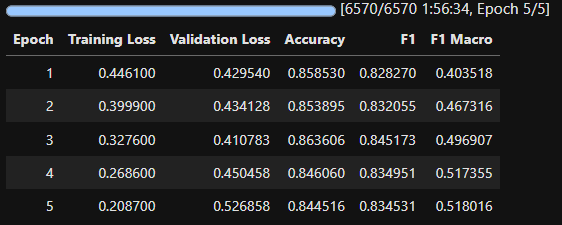

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn( 

================================================================================
🎉 TRAINING COMPLETED SUCCESSFULLY!
================================================================================
📈 Final training loss: 0.3562

📊 Final validation evaluation...
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
  eval_loss: 0.4108
  eval_accuracy: 0.8636
  eval_f1: 0.8452
  eval_f1_macro: 0.4969
  eval_runtime: 101.7551
  eval_samples_per_second: 89.0570
  eval_steps_per_second: 1.3960

🎯 Test set evaluation...
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
🏆 FINAL RESULTS:
  Test Accuracy: 0.8627
  Test F1-Score: 0.8448

💾 Saving final model...

🎊 SUCCESS! Model saved to './final-bangla-fake-news-model'

================================================================================
🏁 TRAINING SESSION COMPLETE
================================================================================
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


In [ ]:
# Discourse-aware Psycholinguistic Framework for Bangla Fake News Detection
# Implementation based on the research paper approach

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from collections import Counter
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

class BanglaPsycholinguisticFeatureExtractor:
    """
    Extract psycholinguistic markers from Bangla text
    Based on established deception detection literature
    """
    
    def __init__(self):
        # Bangla linguistic markers for deception detection
        self.emotional_words = self._load_emotional_lexicon()
        self.formal_markers = self._load_formal_markers()
        self.uncertainty_markers = self._load_uncertainty_markers()
        self.cognitive_load_markers = self._load_cognitive_load_markers()
        
    def _load_emotional_lexicon(self):
        """Load Bangla emotional word lexicon"""
        # High-arousal emotional words often indicate deception
        emotional_words = {
            'positive': ['চমৎকার', 'অসাধারণ', 'দুর্দান্ত', 'বিস্ময়কর', 'অবিশ্বাস্য'],
            'negative': ['ভয়ানক', 'দুর্ভাগ্যজনক', 'বিপজ্জনক', 'ক্ষতিকর', 'মারাত্মক'],
            'fear': ['ভয়', 'আতঙ্ক', 'চিন্তা', 'দুশ্চিন্তা', 'আশঙ্কা'],
            'anger': ['রাগ', 'ক্রোধ', 'বিরক্তি', 'ঘৃণা', 'প্রতিশোধ']
        }
        return emotional_words
    
    def _load_formal_markers(self):
        """Load formal language markers"""
        return {
            'formal_pronouns': ['আমরা', 'তাঁরা', 'উনি', 'তিনি'],
            'informal_pronouns': ['আমি', 'তুমি', 'তোমরা', 'সে', 'ওরা'],
            'formal_verbs': ['করেছেন', 'বলেছেন', 'জানিয়েছেন', 'উল্লেখ করেছেন'],
            'passive_constructions': ['হয়েছে', 'করা হয়েছে', 'বলা হয়েছে']
        }
    
    def _load_uncertainty_markers(self):
        """Load uncertainty and hedging markers"""
        return {
            'hedging': ['সম্ভবত', 'হয়তো', 'মনে হয়', 'বলা যায়', 'ধারণা করা হয়'],
            'uncertainty': ['নিশ্চিত নয়', 'স্পষ্ট নয়', 'অস্পষ্ট', 'সন্দেহজনক'],
            'qualification': ['কিছুটা', 'অনেকটা', 'মোটামুটি', 'প্রায়']
        }
    
    def _load_cognitive_load_markers(self):
        """Load cognitive load indicators"""
        return {
            'complexity': ['জটিল', 'কঠিন', 'বিস্তারিত', 'বিশদ'],
            'simplification': ['সহজ', 'সরল', 'স্পষ্ট', 'পরিষ্কার'],
            'repetition_markers': ['আবার', 'পুনরায়', 'আরেকবার', 'ফিরে']
        }
    
    def extract_psycholinguistic_features(self, text: str) -> Dict[str, float]:
        """Extract comprehensive psycholinguistic features"""
        features = {}
        words = text.split()
        total_words = len(words)
        
        if total_words == 0:
            return {f'psycho_{key}': 0.0 for key in range(20)}
        
        # 1. Emotional intensity features
        features.update(self._extract_emotional_features(text, words, total_words))
        
        # 2. Linguistic complexity features
        features.update(self._extract_complexity_features(text, words, total_words))
        
        # 3. Uncertainty and hedging features
        features.update(self._extract_uncertainty_features(text, words, total_words))
        
        # 4. Cognitive load indicators
        features.update(self._extract_cognitive_load_features(text, words, total_words))
        
        # 5. Deception-specific markers
        features.update(self._extract_deception_markers(text, words, total_words))
        
        return features
    
    def _extract_emotional_features(self, text, words, total_words):
        """Extract emotional markers linked to deception"""
        features = {}
        
        # Count emotional words by category
        for emotion, word_list in self.emotional_words.items():
            count = sum(1 for word in words if any(emo_word in word for emo_word in word_list))
            features[f'psycho_emotion_{emotion}'] = count / total_words
        
        # Emotional intensity (exclamation marks, caps)
        features['psycho_exclamation_ratio'] = text.count('!') / max(len(text), 1)
        features['psycho_caps_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)
        
        return features
    
    def _extract_complexity_features(self, text, words, total_words):
        """Extract linguistic complexity indicators"""
        features = {}
        
        # Sentence complexity
        sentences = re.split(r'[।!?]', text)
        features['psycho_avg_sentence_length'] = np.mean([len(s.split()) for s in sentences if s.strip()])
        
        # Word complexity (average word length)
        features['psycho_avg_word_length'] = np.mean([len(word) for word in words])
        
        # Vocabulary richness (type-token ratio)
        unique_words = len(set(words))
        features['psycho_vocabulary_richness'] = unique_words / total_words
        
        return features
    
    def _extract_uncertainty_features(self, text, words, total_words):
        """Extract uncertainty and hedging markers"""
        features = {}
        
        for marker_type, word_list in self.uncertainty_markers.items():
            count = sum(1 for word in words if any(marker in word for marker in word_list))
            features[f'psycho_{marker_type}'] = count / total_words
        
        return features
    
    def _extract_cognitive_load_features(self, text, words, total_words):
        """Extract cognitive load indicators"""
        features = {}
        
        # Repetition (potential sign of cognitive load)
        word_counts = Counter(words)
        repeated_words = sum(1 for count in word_counts.values() if count > 1)
        features['psycho_repetition_ratio'] = repeated_words / total_words
        
        # Disfluency markers (অর্থাৎ, মানে, etc.)
        disfluency_markers = ['অর্থাৎ', 'মানে', 'যেমন', 'আসলে']
        disfluency_count = sum(1 for word in words if word in disfluency_markers)
        features['psycho_disfluency_ratio'] = disfluency_count / total_words
        
        return features
    
    def _extract_deception_markers(self, text, words, total_words):
        """Extract specific deception indicators from literature"""
        features = {}
        
        # Self-referencing (deceptive texts often have fewer self-references)
        self_refs = ['আমি', 'আমার', 'আমাকে', 'আমাদের']
        self_ref_count = sum(1 for word in words if word in self_refs)
        features['psycho_self_reference'] = self_ref_count / total_words
        
        # Other-referencing (deceptive texts may have more other-references)
        other_refs = ['সে', 'তারা', 'তাদের', 'তার', 'তাকে']
        other_ref_count = sum(1 for word in words if word in other_refs)
        features['psycho_other_reference'] = other_ref_count / total_words
        
        # Present vs past tense (deceptive texts may avoid present tense)
        present_markers = ['আছি', 'আছেন', 'আছে', 'করছি', 'করছেন']
        present_count = sum(1 for word in words if any(marker in word for marker in present_markers))
        features['psycho_present_tense'] = present_count / total_words
        
        return features

class DiscourseAnalyzer:
    """
    Analyze discourse structure and coherence patterns
    """
    
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
    
    def extract_discourse_features(self, text: str) -> Dict[str, float]:
        """Extract discourse-level features"""
        features = {}
        
        # Split into discourse segments (paragraphs)
        paragraphs = [p.strip() for p in text.split('\n') if p.strip()]
        
        if len(paragraphs) == 0:
            return {f'discourse_{key}': 0.0 for key in range(10)}
        
        # 1. Coherence analysis
        features.update(self._analyze_coherence(paragraphs))
        
        # 2. Topic progression
        features.update(self._analyze_topic_progression(paragraphs))
        
        # 3. Argumentative structure
        features.update(self._analyze_argumentative_structure(text, paragraphs))
        
        return features
    
    def _analyze_coherence(self, paragraphs):
        """Analyze semantic coherence across paragraphs"""
        features = {}
        
        if len(paragraphs) < 2:
            features['discourse_coherence_score'] = 1.0
            return features
        
        # Get embeddings for each paragraph
        embeddings = []
        for paragraph in paragraphs:
            inputs = self.tokenizer(paragraph, return_tensors='pt', 
                                  padding=True, truncation=True, max_length=256)
            with torch.no_grad():
                outputs = self.model(**inputs)
                embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
                embeddings.append(embedding)
        
        # Calculate coherence as average cosine similarity between adjacent paragraphs
        coherence_scores = []
        for i in range(len(embeddings) - 1):
            similarity = torch.cosine_similarity(embeddings[i], embeddings[i+1], dim=0)
            coherence_scores.append(similarity.item())
        
        features['discourse_coherence_score'] = np.mean(coherence_scores)
        features['discourse_coherence_variance'] = np.var(coherence_scores)
        
        return features
    
    def _analyze_topic_progression(self, paragraphs):
        """Analyze topic progression patterns"""
        features = {}
        
        # Topic shift indicators
        transition_words = ['তবে', 'কিন্তু', 'অন্যদিকে', 'এছাড়া', 'আবার', 'এরপর']
        
        total_transitions = 0
        for paragraph in paragraphs:
            for word in transition_words:
                total_transitions += paragraph.count(word)
        
        features['discourse_topic_transitions'] = total_transitions / len(paragraphs)
        
        return features
    
    def _analyze_argumentative_structure(self, text, paragraphs):
        """Analyze argumentative and rhetorical structure"""
        features = {}
        
        # Claim markers
        claim_markers = ['দাবি করা হয়', 'অভিযোগ', 'বলা হয়', 'জানা গেছে']
        evidence_markers = ['প্রমাণ', 'তথ্য', 'উদাহরণ', 'পরিসংখ্যান']
        
        claim_count = sum(text.count(marker) for marker in claim_markers)
        evidence_count = sum(text.count(marker) for marker in evidence_markers)
        
        features['discourse_claim_ratio'] = claim_count / len(paragraphs)
        features['discourse_evidence_ratio'] = evidence_count / len(paragraphs)
        features['discourse_claim_evidence_balance'] = evidence_count / max(claim_count, 1)
        
        return features

class IntegratedDiscourseModel(nn.Module):
    """
    Integrated model combining BERT embeddings with discourse and psycholinguistic features
    """
    
    def __init__(self, model_name, num_labels=4, psycho_features=20, discourse_features=10):
        super().__init__()
        
        # Load pre-trained BERT
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        
        # Feature dimensions
        bert_hidden_size = self.bert.config.hidden_size
        total_features = bert_hidden_size + psycho_features + discourse_features
        
        # Classification layers
        self.feature_fusion = nn.Linear(total_features, bert_hidden_size)
        self.classifier = nn.Linear(bert_hidden_size, num_labels)
        
        # Feature importance (for interpretability)
        self.feature_attention = nn.Linear(total_features, 1)
        
    def forward(self, input_ids, attention_mask, psycho_features, discourse_features):
        # Get BERT embeddings
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_pooled = bert_outputs.pooler_output
        
        # Combine all features
        combined_features = torch.cat([
            bert_pooled, 
            psycho_features, 
            discourse_features
        ], dim=1)
        
        # Feature fusion with attention
        attention_weights = torch.softmax(self.feature_attention(combined_features), dim=1)
        weighted_features = combined_features * attention_weights
        
        # Final classification
        fused_features = self.dropout(self.feature_fusion(weighted_features))
        logits = self.classifier(fused_features)
        
        return {
            'logits': logits,
            'attention_weights': attention_weights,
            'bert_features': bert_pooled,
            'psycho_features': psycho_features,
            'discourse_features': discourse_features
        }

class InterpretabilityAnalyzer:
    """
    Provide interpretable explanations for model decisions
    """
    
    def __init__(self, model, psycho_extractor, discourse_analyzer):
        self.model = model
        self.psycho_extractor = psycho_extractor
        self.discourse_analyzer = discourse_analyzer
        
    def explain_prediction(self, text: str, prediction: int, confidence: float):
        """Provide human-readable explanation for prediction"""
        
        # Extract features
        psycho_features = self.psycho_extractor.extract_psycholinguistic_features(text)
        discourse_features = self.discourse_analyzer.extract_discourse_features(text)
        
        explanation = {
            'prediction': prediction,
            'confidence': confidence,
            'psycholinguistic_indicators': self._interpret_psycho_features(psycho_features),
            'discourse_indicators': self._interpret_discourse_features(discourse_features),
            'decision_factors': self._rank_decision_factors(psycho_features, discourse_features)
        }
        
        return explanation
    
    def _interpret_psycho_features(self, features):
        """Interpret psycholinguistic features"""
        indicators = []
        
        # High emotional intensity
        if features.get('psycho_emotion_negative', 0) > 0.05:
            indicators.append("High negative emotional language detected")
        
        # Uncertainty markers
        if features.get('psycho_hedging', 0) > 0.03:
            indicators.append("Excessive hedging language (uncertainty)")
        
        # Cognitive load
        if features.get('psycho_repetition_ratio', 0) > 0.3:
            indicators.append("High repetition (potential cognitive load)")
        
        # Self-reference patterns
        if features.get('psycho_self_reference', 0) < 0.01:
            indicators.append("Unusually low self-reference (deception marker)")
        
        return indicators
    
    def _interpret_discourse_features(self, features):
        """Interpret discourse-level features"""
        indicators = []
        
        # Coherence issues
        if features.get('discourse_coherence_score', 1.0) < 0.5:
            indicators.append("Low discourse coherence detected")
        
        # Claim-evidence imbalance
        if features.get('discourse_claim_evidence_balance', 1.0) < 0.3:
            indicators.append("Claims not supported by evidence")
        
        return indicators
    
    def _rank_decision_factors(self, psycho_features, discourse_features):
        """Rank the most important decision factors"""
        # This would be implemented based on feature importance from the model
        factors = []
        
        all_features = {**psycho_features, **discourse_features}
        
        # Sort features by absolute value (importance)
        sorted_features = sorted(all_features.items(), 
                               key=lambda x: abs(x[1]), reverse=True)
        
        for feature, value in sorted_features[:5]:
            factors.append({
                'feature': feature,
                'value': value,
                'interpretation': self._interpret_single_feature(feature, value)
            })
        
        return factors
    
    def _interpret_single_feature(self, feature, value):
        """Provide interpretation for individual feature"""
        interpretations = {
            'psycho_emotion_negative': 'Negative emotional language intensity',
            'psycho_hedging': 'Use of uncertain/hedging language',
            'discourse_coherence_score': 'Overall text coherence',
            'psycho_self_reference': 'Self-referential language use',
            'discourse_claim_evidence_balance': 'Balance between claims and evidence'
        }
        
        return interpretations.get(feature, f"Feature {feature}")

# Example usage and evaluation
def demonstrate_framework():
    """Demonstrate the discourse-aware psycholinguistic framework"""
    
    # Initialize components
    tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
    bert_model = AutoModel.from_pretrained("sagorsarker/bangla-bert-base")
    
    psycho_extractor = BanglaPsycholinguisticFeatureExtractor()
    discourse_analyzer = DiscourseAnalyzer(tokenizer, bert_model)
    
    # Example text analysis
    sample_text = """
    চাঞ্চল্যকর খবর! প্রধানমন্ত্রী নাকি গোপন সভায় বলেছেন যে দেশের অর্থনীতি ভেঙে পড়েছে। 
    এই তথ্য নিশ্চিত নয় তবে একটি সূত্র জানিয়েছে। আমাদের মনে হয় এটি সত্য হতে পারে।
    """
    
    # Extract features
    psycho_features = psycho_extractor.extract_psycholinguistic_features(sample_text)
    discourse_features = discourse_analyzer.extract_discourse_features(sample_text)
    
    print("Psycholinguistic Features:")
    for key, value in psycho_features.items():
        if value > 0:
            print(f"  {key}: {value:.4f}")
    
    print("\nDiscourse Features:")
    for key, value in discourse_features.items():
        if value > 0:
            print(f"  {key}: {value:.4f}")
    
    return psycho_features, discourse_features

if __name__ == "__main__":
    demonstrate_framework()

Psycholinguistic Features:
  psycho_exclamation_ratio: 0.0056
  psycho_avg_sentence_length: 6.7500
  psycho_avg_word_length: 5.0741
  psycho_vocabulary_richness: 1.0000
  psycho_self_reference: 0.0370

Discourse Features:
  discourse_coherence_score: 0.6363
  discourse_topic_transitions: 0.5000
  discourse_evidence_ratio: 0.5000
  discourse_claim_evidence_balance: 1.0000

In [ ]:
train_df = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/train_cleaned.csv")
val_df = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/val_cleaned.csv") 
test_df = pd.read_csv("/kaggle/input/banfakenews-2-0-bangla-fake-news-dataset/test_cleaned.csv")

for df in [train_df, val_df, test_df]:
    df['combined_text'] = df['Headline'].astype(str) + ' ' + df['Content'].astype(str)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
bert_model = AutoModel.from_pretrained("sagorsarker/bangla-bert-base")

psycho_extractor = BanglaPsycholinguisticFeatureExtractor()
discourse_analyzer = DiscourseAnalyzer(tokenizer, bert_model)

In [ ]:
# Fixed feature extraction with consistent feature vectors
def extract_all_features_fixed(df, psycho_extractor, discourse_analyzer):
    psycho_features_list = []
    discourse_features_list = []
    
    # First, determine the expected feature dimensions by testing one sample
    sample_text = df.iloc[0]['combined_text']
    sample_psycho = psycho_extractor.extract_psycholinguistic_features(sample_text)
    sample_discourse = discourse_analyzer.extract_discourse_features(sample_text)
    
    psycho_feature_names = list(sample_psycho.keys())
    discourse_feature_names = list(sample_discourse.keys())
    
    print(f"Expected psycholinguistic features: {len(psycho_feature_names)}")
    print(f"Expected discourse features: {len(discourse_feature_names)}")
    
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(f"Processed {idx}/{len(df)} samples")
        
        text = row['combined_text']
        
        try:
            # Extract features
            psycho_features = psycho_extractor.extract_psycholinguistic_features(text)
            discourse_features = discourse_analyzer.extract_discourse_features(text)
            
            # Ensure consistent feature ordering and handle missing features
            psycho_vector = []
            for feature_name in psycho_feature_names:
                psycho_vector.append(psycho_features.get(feature_name, 0.0))
            
            discourse_vector = []
            for feature_name in discourse_feature_names:
                discourse_vector.append(discourse_features.get(feature_name, 0.0))
            
            psycho_features_list.append(psycho_vector)
            discourse_features_list.append(discourse_vector)
            
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            # Add zero vectors for failed samples
            psycho_features_list.append([0.0] * len(psycho_feature_names))
            discourse_features_list.append([0.0] * len(discourse_feature_names))
    
    return np.array(psycho_features_list), np.array(discourse_features_list)

# Extract features with the fixed function
print("Extracting features with consistent dimensions...")
train_psycho, train_discourse = extract_all_features_fixed(train_df, psycho_extractor, discourse_analyzer)
val_psycho, val_discourse = extract_all_features_fixed(val_df, psycho_extractor, discourse_analyzer)  
test_psycho, test_discourse = extract_all_features_fixed(test_df, psycho_extractor, discourse_analyzer)

print(f"Feature extraction complete!")
print(f"Train psycholinguistic features shape: {train_psycho.shape}")
print(f"Train discourse features shape: {train_discourse.shape}")

# Save the extracted features
np.save('train_psycho_features.npy', train_psycho)
np.save('train_discourse_features.npy', train_discourse)
np.save('val_psycho_features.npy', val_psycho)
np.save('val_discourse_features.npy', val_discourse)
np.save('test_psycho_features.npy', test_psycho)
np.save('test_discourse_features.npy', test_discourse)

print("Features saved successfully!")

Extracting features with consistent dimensions...
Expected psycholinguistic features: 17
Expected discourse features: 5
Processed 0/42380 samples
Processed 1000/42380 samples
Processed 2000/42380 samples
Processed 3000/42380 samples
Processed 4000/42380 samples
Processed 5000/42380 samples
Processed 6000/42380 samples
Processed 7000/42380 samples
Processed 8000/42380 samples
Processed 9000/42380 samples
Processed 10000/42380 samples
Processed 11000/42380 samples
Processed 12000/42380 samples
Processed 13000/42380 samples
Processed 14000/42380 samples
Processed 15000/42380 samples
Processed 16000/42380 samples
Processed 17000/42380 samples
Processed 18000/42380 samples
Processed 19000/42380 samples
Processed 20000/42380 samples
Processed 21000/42380 samples
Processed 22000/42380 samples
Processed 23000/42380 samples
Processed 24000/42380 samples
Processed 25000/42380 samples
Processed 26000/42380 samples
Processed 27000/42380 samples
Processed 28000/42380 samples
Processed 29000/42380 samples
Processed 30000/42380 samples
Processed 31000/42380 samples
Processed 32000/42380 samples
Processed 33000/42380 samples
Processed 34000/42380 samples
Processed 35000/42380 samples
Processed 36000/42380 samples
Processed 37000/42380 samples
Processed 38000/42380 samples
Processed 39000/42380 samples
Processed 40000/42380 samples
Processed 41000/42380 samples
Processed 42000/42380 samples
Expected psycholinguistic features: 17
Expected discourse features: 5
Processed 0/9082 samples
Processed 1000/9082 samples
Processed 2000/9082 samples
Processed 3000/9082 samples
Processed 4000/9082 samples
Processed 5000/9082 samples
Processed 6000/9082 samples
Processed 7000/9082 samples
Processed 8000/9082 samples
Processed 9000/9082 samples
Expected psycholinguistic features: 17
Expected discourse features: 5
Processed 0/9082 samples
Processed 1000/9082 samples
Processed 2000/9082 samples
Processed 3000/9082 samples
Processed 4000/9082 samples
Processed 5000/9082 samples
Processed 6000/9082 samples
Processed 7000/9082 samples
Processed 8000/9082 samples
Processed 9000/9082 samples
Feature extraction complete!
Train psycholinguistic features shape: (42380, 17)
Train discourse features shape: (42380, 5)
Features saved successfully!

In [ ]:
# Create the interpretable dataset class
class InterpretableDataset(torch.utils.data.Dataset):
    def __init__(self, df, psycho_features, discourse_features, tokenizer, max_len=256):
        self.texts = df['combined_text'].tolist()
        self.labels = df['Label'].tolist()
        self.psycho_features = torch.FloatTensor(psycho_features)
        self.discourse_features = torch.FloatTensor(discourse_features)
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "psycho_features": self.psycho_features[idx],
            "discourse_features": self.discourse_features[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = InterpretableDataset(train_df, train_psycho, train_discourse, tokenizer)
val_dataset = InterpretableDataset(val_df, val_psycho, val_discourse, tokenizer)
test_dataset = InterpretableDataset(test_df, test_psycho, test_discourse, tokenizer)

print(f"Interpretable datasets created:")
print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Interpretable datasets created:
Train: 42380 samples
Val: 9082 samples
Test: 9082 samples

In [ ]:
# Let's create a custom data collator that properly handles our features
from transformers import DataCollatorWithPadding

class InterpretableDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def __call__(self, features):
        # Separate different types of features
        input_ids = [f["input_ids"] for f in features]
        attention_masks = [f["attention_mask"] for f in features]
        psycho_features = [f["psycho_features"] for f in features]
        discourse_features = [f["discourse_features"] for f in features]
        labels = [f["labels"] for f in features]
        
        # Stack features into batches
        batch = {
            "input_ids": torch.stack(input_ids),
            "attention_mask": torch.stack(attention_masks),
            "psycho_features": torch.stack(psycho_features),
            "discourse_features": torch.stack(discourse_features),
            "labels": torch.stack(labels)
        }
        
        return batch

# Create a standard model that works with Trainer's expectations
class StandardIntegratedModel(nn.Module):
    def __init__(self, model_name, num_labels=4, psycho_features=17, discourse_features=5):
        super().__init__()
        
        # Load BERT
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        
        # Feature dimensions
        bert_hidden_size = self.bert.config.hidden_size
        total_features = bert_hidden_size + psycho_features + discourse_features
        
        # Classification layers
        self.feature_fusion = nn.Linear(total_features, bert_hidden_size)
        self.classifier = nn.Linear(bert_hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask, psycho_features, discourse_features, labels=None):
        # Get BERT embeddings
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_pooled = bert_outputs.pooler_output
        
        # Combine all features
        combined_features = torch.cat([
            bert_pooled, 
            psycho_features, 
            discourse_features
        ], dim=1)
        
        # Final classification
        fused_features = self.dropout(self.feature_fusion(combined_features))
        logits = self.classifier(fused_features)
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
        
        return {"loss": loss, "logits": logits}

# Create new model
model = StandardIntegratedModel(
    model_name="sagorsarker/bangla-bert-base",
    num_labels=4,
    psycho_features=17,
    discourse_features=5
).to(device)

print(f"Standard integrated model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# Create data collator
data_collator = InterpretableDataCollator(tokenizer)

# Use standard Trainer with data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_interpretable_metrics,
    data_collator=data_collator,
)

print("Starting training with standard Trainer and custom data collator...")
train_result = trainer.train()
print(f"Training completed! Final loss: {train_result.training_loss:.4f}")

Standard integrated model created with 165,007,108 parameters
Starting training with standard Trainer and custom data collator...
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

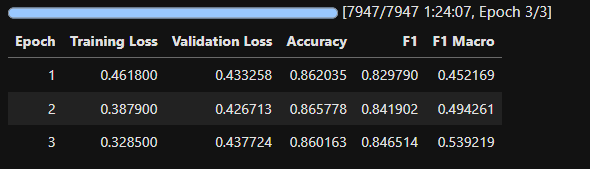

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
Training completed! Final loss: 0.4156

In [ ]:
# Evaluate current model state
print("Evaluating current model...")
eval_result = trainer.evaluate()
print(f"Current evaluation results: {eval_result}")

# Test on test set
test_result = trainer.predict(test_dataset)
test_preds = test_result.predictions.argmax(-1)
test_labels = test_result.label_ids

from sklearn.metrics import accuracy_score, f1_score
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Save current model
trainer.save_model("./interpretable-model-partial")

Evaluating current model...
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Current evaluation results: {'eval_loss': 0.4377244710922241, 'eval_accuracy': 0.8601629597005065, 'eval_f1': 0.8465144415369399, 'eval_f1_macro': 0.5392189033207623, 'eval_runtime': 103.123, 'eval_samples_per_second': 88.07, 'eval_steps_per_second': 2.754, 'epoch': 3.0}
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Test Results:
Accuracy: 0.8573
F1-Score: 0.8437
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !

In [ ]:
# Install huggingface_hub if not already installed
!pip install huggingface_hub

# Login to Hugging Face (you'll need to create account first at huggingface.co)
from huggingface_hub import login
login()  # This will prompt for your token

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Requirement already satisfied: huggingface_hub in /usr/local/lib/python3.11/dist-packages (0.33.1)
Requirement already satisfied: filelock in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (3.18.0)
Requirement already satisfied: fsspec>=2023.5.0 in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (2025.5.1)
Requirement already satisfied: packaging>=20.9 in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (25.0)
Requirement already satisfied: pyyaml>=5.1 in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (6.0.2)
Requirement already satisfied: requests in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (2.32.4)
Requirement already satisfied: tqdm>=4.42.1 in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (4.67.1)
Requirement already satisfied: typing-extensions>=3.7.4.3 in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (4.14.0)
Requirement already satisfied: hf-xet<2.0.0,>=1.1.2 in /usr/local/lib/python3.11/dist-packages (from huggingface_hub) (1.1.5)
Requirement already satisfied: charset_normalizer<4,>=2 in /usr/local/lib/python3.11/dist-packages (from requests->huggingface_hub) (3.4.2)
Requirement already satisfied: idna<4,>=2.5 in /usr/local/lib/python3.11/dist-packages (from requests->huggingface_hub) (3.10)
Requirement already satisfied: urllib3<3,>=1.21.1 in /usr/local/lib/python3.11/dist-packages (from requests->huggingface_hub) (2.5.0)
Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/python3.11/dist-packages (from requests->huggingface_hub) (2025.6.15)
[1m[31mCannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.
git config --global credential.helper store
Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.[0

In [ ]:
from huggingface_hub import login

# This will prompt you to enter your Hugging Face token
# Get your token from: https://huggingface.co/settings/tokens
login()

In [ ]:
# Check both interpretable models
models_to_check = [
    "./interpretable-bangla-fake-news/checkpoint-7947",
    "./interpretable-model-partial"
]

for model_path in models_to_check:
    print(f"\nChecking: {model_path}")
    if os.path.exists(model_path):
        files = os.listdir(model_path)
        print(f"Files: {files}")
        
        # Check for essential model files
        has_config = 'config.json' in files
        has_model = any(f in files for f in ['model.safetensors', 'pytorch_model.bin'])
        has_tokenizer = any('tokenizer' in f for f in files)
        
        print(f"Has config: {has_config}")
        print(f"Has model weights: {has_model}")
        print(f"Has tokenizer: {has_tokenizer}")

Checking: ./interpretable-bangla-fake-news/checkpoint-7947
Files: ['trainer_state.json', 'tokenizer.json', 'optimizer.pt', 'rng_state.pth', 'vocab.txt', 'tokenizer_config.json', 'special_tokens_map.json', 'scheduler.pt', 'model.safetensors', 'training_args.bin']
Has config: False
Has model weights: True
Has tokenizer: True

Checking: ./interpretable-model-partial
Files: ['tokenizer.json', 'vocab.txt', 'tokenizer_config.json', 'special_tokens_map.json', 'model.safetensors', 'training_args.bin']
Has config: False
Has model weights: True
Has tokenizer: True

In [ ]:
# Create config.json for your interpretable model
import json

# Generate config based on your model architecture
config = {
    "architectures": ["StandardIntegratedModel"],
    "model_type": "bert",
    "num_labels": 4,
    "id2label": {
        "0": "Class_0", 
        "1": "Class_1",
        "2": "Class_2", 
        "3": "Class_3"
    },
    "label2id": {
        "Class_0": 0,
        "Class_1": 1, 
        "Class_2": 2,
        "Class_3": 3
    },
    "hidden_size": 768,
    "vocab_size": 30522,
    "max_position_embeddings": 512,
    "torch_dtype": "float32",
    "transformers_version": "4.56.1"
}

# Save config to both model directories
model_dirs = [
    "./interpretable-bangla-fake-news/checkpoint-7947",
    "./interpretable-model-partial"
]

for model_dir in model_dirs:
    config_path = os.path.join(model_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=2)
    print(f"Config saved to: {config_path}")

print("Config files created successfully!")

Config saved to: ./interpretable-bangla-fake-news/checkpoint-7947/config.json
Config saved to: ./interpretable-model-partial/config.json
Config files created successfully!

In [ ]:
# Compare both models after adding config
for model_path in models_to_check:
    print(f"\nChecking updated: {model_path}")
    files = os.listdir(model_path)
    
    essential_files = ['config.json', 'model.safetensors', 'tokenizer.json', 'vocab.txt']
    has_all = all(f in files for f in essential_files)
    
    print(f"Has all essential files: {has_all}")
    if has_all:
        print(f"✓ Ready for upload: {model_path}")

Checking updated: ./interpretable-bangla-fake-news/checkpoint-7947
Has all essential files: True
✓ Ready for upload: ./interpretable-bangla-fake-news/checkpoint-7947

Checking updated: ./interpretable-model-partial
Has all essential files: True
✓ Ready for upload: ./interpretable-model-partial

In [ ]:
from huggingface_hub import HfApi, upload_folder

# Initialize API
api = HfApi()

# Your repository details
username = "NUHASHROXME"
repo_name = "bangla-fake-news-interpretable"
repo_id = f"{username}/{repo_name}"

print(f"Creating repository: {repo_id}")

# Create the repository
try:
    api.create_repo(repo_id=repo_id, exist_ok=True, private=False)
    print("Repository created successfully!")
except Exception as e:
    print(f"Repository creation: {e}")

# Use the more complete model (checkpoint-7947)
model_path = "./interpretable-bangla-fake-news/checkpoint-7947"

# Upload the model
try:
    upload_folder(
        folder_path=model_path,
        repo_id=repo_id,
        commit_message="Upload interpretable Bangla fake news detection model",
        ignore_patterns=["*.pt", "*.pth"]  # Skip optimizer states to reduce size
    )
    print("Model uploaded successfully!")
    print(f"Model available at: https://huggingface.co/{repo_id}") 
except Exception as e:
    print(f"Upload failed: {e}")

Creating repository: NUHASHROXME/bangla-fake-news-interpretable
Repository created successfully!
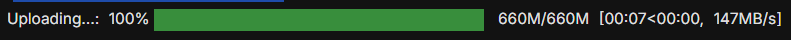

Model uploaded successfully!
Model available at: https://huggingface.co/NUHASHROXME/bangla-fake-news-interpretable